/var/folders/_9/gvwygmmj7mn8j8w4btg7nt0r0000gn/T/ipykernel_92554/14659156.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500.index = pd.to_datetime(sp500.index)


1.0
Predictions
0    12283
1     9441
Name: count, dtype: int64
0.5165766338311619
Target
1    0.52633
0    0.47367
Name: count, dtype: float64
Predictions
0.0    17556
1.0     3168
Name: count, dtype: int64
0.5965909090909091
Target
1    0.529
0    0.471
Name: count, dtype: float64


,Target,Predictions
Date,,
1942-01-07 00:00:00-05:00,0,0.0
1942-01-08 00:00:00-05:00,0,0.0
1942-01-09 00:00:00-05:00,0,0.0
1942-01-12 00:00:00-05:00,1,0.0
1942-01-13 00:00:00-05:00,0,0.0
...,...,...
2024-05-31 00:00:00-04:00,1,1.0
2024-06-03 00:00:00-04:00,1,0.0
2024-06-04 00:00:00-04:00,1,0.0


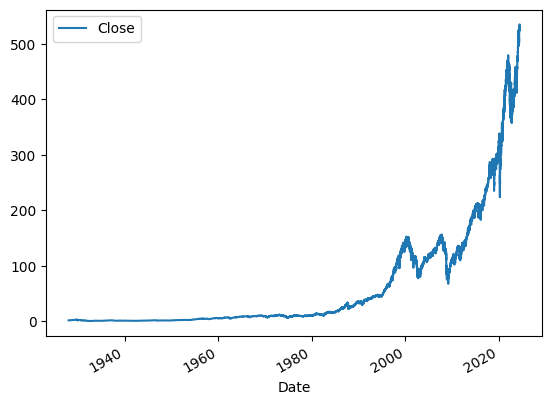

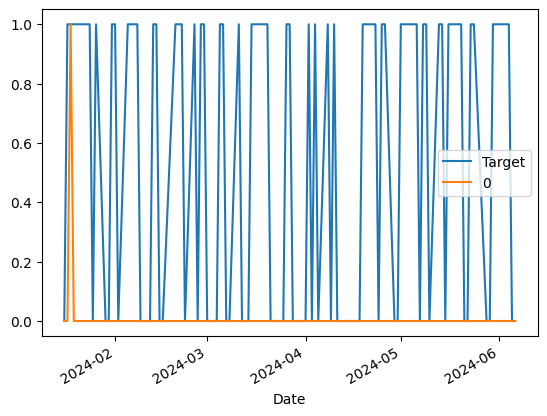

In [1]:
import yfinance as yf
import pandas as pd
import os

# Load or fetch S&P 500 data
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

# Convert index to datetime
sp500.index = pd.to_datetime(sp500.index)

# Correct the prices by dividing by 10
sp500["Open"] = sp500["Open"] / 10
sp500["High"] = sp500["High"] / 10
sp500["Low"] = sp500["Low"] / 10
sp500["Close"] = sp500["Close"] / 10

# Plot the adjusted closing prices
sp500.plot.line(y="Close", use_index=True)

# Prepare data for modeling
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Train initial model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

# Evaluate initial model
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
print(precision_score(test["Target"], preds))

# Plot predictions vs actuals
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

# Define prediction function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Define backtesting function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# Perform backtesting
predictions = backtest(sp500, model, predictors)
print(predictions["Predictions"].value_counts())
print(precision_score(predictions["Target"], predictions["Predictions"]))
print(predictions["Target"].value_counts() / predictions.shape[0])

# Feature engineering with rolling averages and trends
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

# Drop rows with NaN values
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

# Re-initialize the model with new parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Update prediction function to use probability thresholds
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Perform backtesting with new predictors
predictions = backtest(sp500, model, new_predictors)
print(predictions["Predictions"].value_counts())
print(precision_score(predictions["Target"], predictions["Predictions"]))
print(predictions["Target"].value_counts() / predictions.shape[0])

predictions
